### We can match the tweezer depths for a given difference in waist, but need to apply an offset to the power to be in the no-crossover regime. Here I want to find what the best value for that offset is.

In [ ]:
from helpers_merging import *

initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 3*si.um

trap: DoubleTweezer = DoubleTweezer(
    power=0,  # Set pancake laser power to 0, no 2D trap
    grad_z= 0*si.G/si.cm,
    grad_r=0,
    power_tweezer1 = initial_power,     #stationary
    power_tweezer2 = initial_power,     #transfer tweezer
    waist_tweezer1 = initial_waist,     #stationary
    waist_tweezer2 = initial_waist*1.075,     #transfer tweezer
    distance_tweezers = initial_distance,

    a=180*(4 * np.pi * const.epsilon_0 * const.value("Bohr radius")**3)/(2 * const.epsilon_0 * const.c),
    wvl = 532 * si.nm,

    g = 0,
)

x, y, z = trap.x, trap.y, trap.z

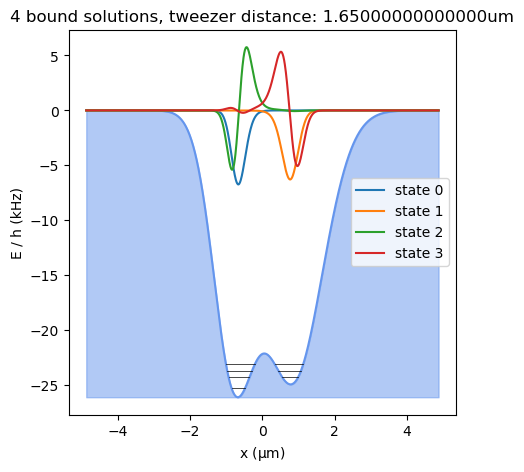

In [ ]:
left_cutoff = -0.5*initial_distance-3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])
right_cutoff = 0.5*initial_distance+3*np.max([float(trap.subs(trap.waist_tweezer1)),float(trap.subs(trap.waist_tweezer2))])

trap[trap.distance_tweezers] = 0.55*initial_distance
trap[trap.power_tweezer2] = initial_power*2.5
trap[trap.waist_tweezer2] = initial_waist*1.5
plot_solutions(trap,4,left_cutoff,right_cutoff,display_plot=-1,state_mult=40,n_pot_steps=1000,plot=True,ret_results=False)

In [3]:
def get_deltaE(power_tweezer1, power_tweezer2, waist_tweezer1, waist_tweezer2,
               n_levels=10,n_pot_steps=2000, initial_distance=4*si.um, plot=True):
    """
    Returns the minimal energy gap and occupation numbers of the groundstate when the two tweezers merge.
    """
    trap[trap.power_tweezer1] = power_tweezer1
    trap[trap.power_tweezer2] = power_tweezer2
    trap[trap.waist_tweezer1] = waist_tweezer1
    trap[trap.waist_tweezer2] = waist_tweezer2

    distances = np.linspace(initial_distance,0*si.um,500) #always has to have smallest distance at last index
    energies, states, potentials = loop_distances(trap, distances,n_levels=n_levels,n_pot_steps=n_pot_steps)

    new_energies, new_states, new_potentials, index_top, index, swap_index = swapped_loop_distance(distances, energies, states, potentials)
    energies_left, energies_right, states_left, states_right = find_ass_tweezer(new_energies,new_states, return_deltaE=False)

    if len(index)!=0:
        deltaE_min = 0
        print("crossover")
    else:
        deltaE_min = np.inf
        for i in range(energies_left.shape[1]):
            for j in range(energies_right.shape[1]):
                row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))
                if row_diff<deltaE_min:
                    deltaE_min = row_diff
                    i_min, j_min = i,j
        print(f"closest approach between states: left:{i_min}, right:{j_min}")

    if plot:
        # Create the figure with two subplots (1 row, 2 columns)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        # Plot the full range on ax1
        """
        ax1.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
        ax1.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
        ax1.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
        ax1.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
        ax1.plot(distances/si.um, energies_left[:], color="red", label="left tweezer")
        ax1.plot(distances/si.um, energies_right[:], color="blue", label="right tweezer")

        for i, ind in enumerate(index):
            ax1.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="energy crossings")

        ax1.set_xlabel("Tweezer distance [um]")
        ax1.set_ylabel("Eigenenergy [a.u.]")
        ax1.set_title(fr"$p_l={float(trap.subs(trap.power_tweezer1))/si.uW:.1f}$ uW, $p_r={float(trap.subs(trap.power_tweezer2))/si.uW:.1f}$ uW, $w_l={float(trap.subs(trap.waist_tweezer1))/si.um:.3f}$ um, $w_r={float(trap.subs(trap.waist_tweezer2))/si.um:.3f}$ um")
        ax1.grid()

        # Plot the zoomed-in range (1 to 1.5 µm) on ax2
        """
        ax2.plot(distances/si.um, energies_left[:, 0], color="red", label="GS left tweezer")
        ax2.plot(distances/si.um, energies_right[:, 0], color="blue", label="GS right tweezer")
        ax2.plot(distances/si.um, energies_left[:, 1:], color="red", linestyle="dotted", label="left tweezer")
        ax2.plot(distances/si.um, energies_right[:, 1:], color="blue", linestyle="dotted", label="right tweezer")"""
        ax2.plot(distances/si.um, energies_left[:], color="red", label="left tweezer")
        ax2.plot(distances/si.um, energies_right[:], color="blue", label="right tweezer")

        for i, ind in enumerate(index):
            ax2.axvline(distances[ind]/si.um, color="k", alpha=0.7, label="energy crossings")

        ax2.set_xlabel("Tweezer distance [um]")
        ax2.set_ylabel("Eigenenergy [a.u.]")
        ax2.set_title("Zoomed-in Region")
        ax2.set_xlim(0.7, 1)  # Zooming in on the region between 1.0 and 1.5 µm
        ax2.set_ylim(-7e-28,-5e-28)
        ax2.grid()

        # Remove duplicates in the legend (labels that appear in both subplots)
        handles, labels = ax1.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))  # Remove duplicates
        ax1.legend(unique_labels.values(), unique_labels.keys())

        # Show the plots
        plt.tight_layout()
        plt.show()

    return deltaE_min

crossover


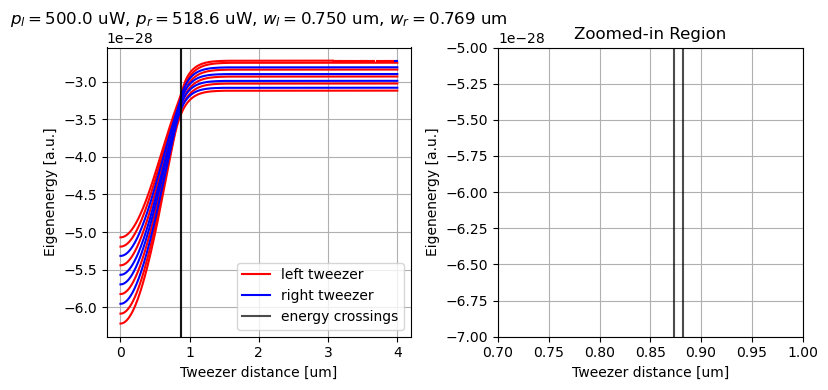

0


In [ ]:
initial_power = 500*si.uW
initial_waist = 0.75*si.um
initial_distance = 2*si.um

factor_waist2 = 1.025

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.42*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

closest approach between states: left:4, right:4


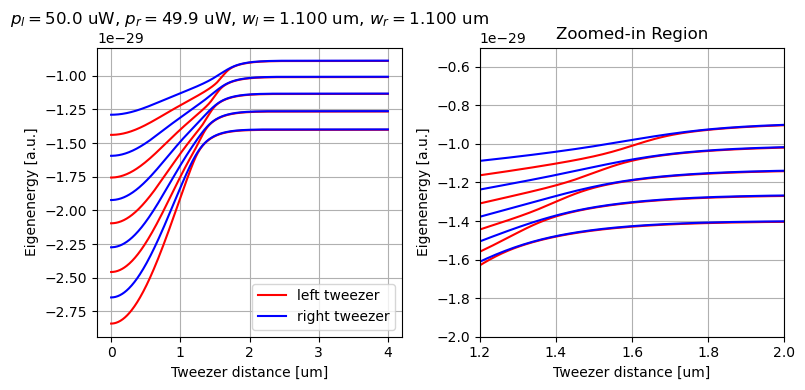

2.1070827342779715e-32


In [66]:
factor_waist2 = 1.0

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.02*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

closest approach between states: left:4, right:4


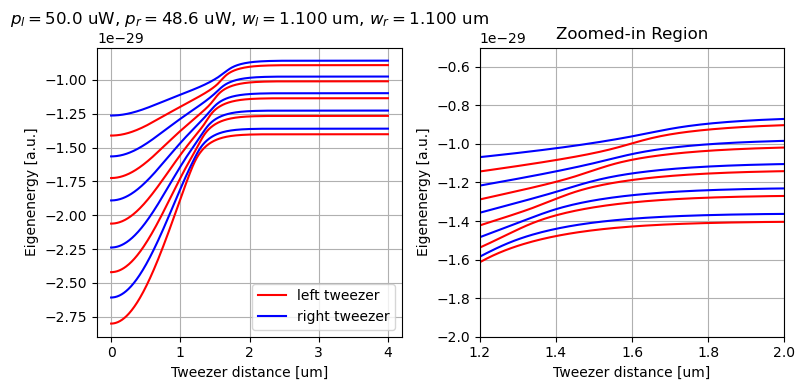

2.818007561261679e-31


In [63]:
factor_waist2 = 1.0

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.3*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

closest approach between states: left:1, right:0


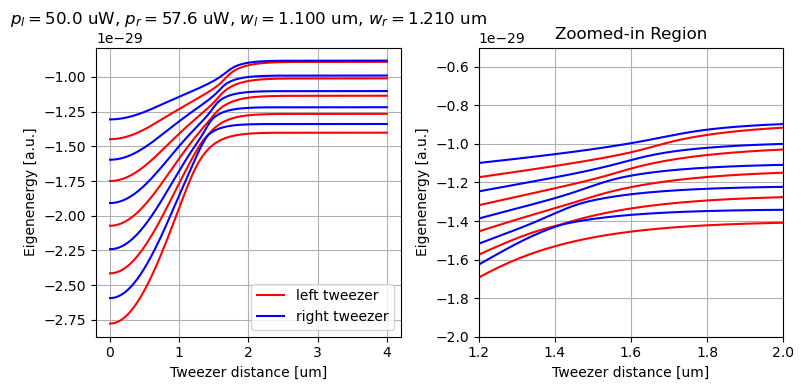

1.9577544578567123e-32


In [120]:
factor_waist2 = 1.1

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.5*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

closest approach between states: left:1, right:0


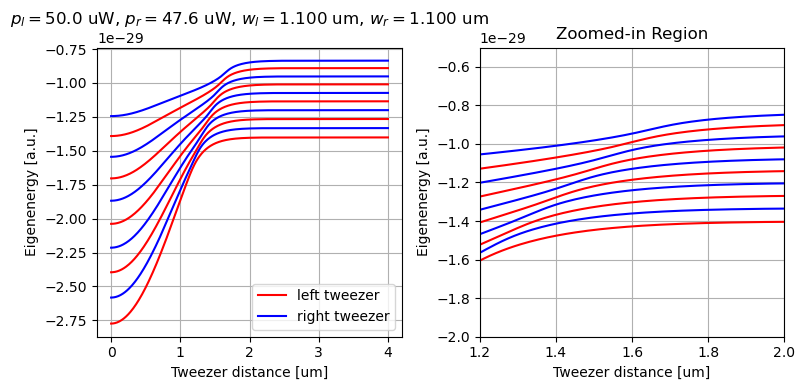

3.2369169874679794e-31


In [121]:
factor_waist2 = 1.

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2
omega_r2 = sp.sqrt(2*trap.power_tweezer2*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer2**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.5*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

## Analyse how minimal energy difference behaves with fraction of level spacing:

closest approach between states: left:1, right:0


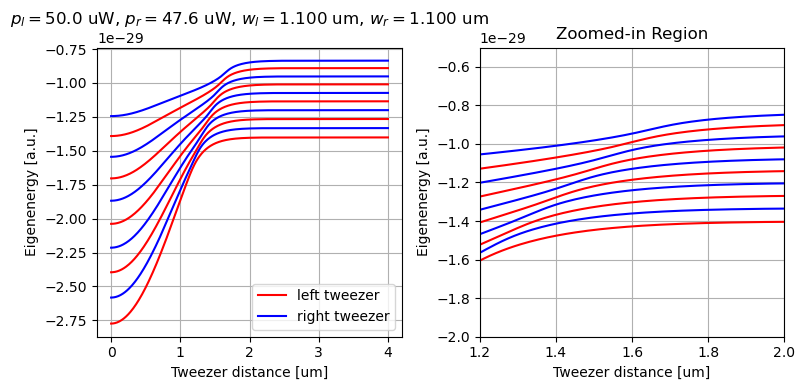

3.2369169874680354e-31


In [ ]:
initial_power = 50* si.uW
initial_waist = 1.1*si.uW
initial_distance = 3*si.um

factor_waist2 = 1.

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.5*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

In [ ]:
level_spacings = np.linspace(0,1,20)
relative_waists = np.linspace(1,1.1,4)
delta_E = np.full((len(level_spacings),len(relative_waists)),np.nan)

for i, space_fac in enumerate(level_spacings):
    for j, factor_waist2 in enumerate(relative_waists):

        trap[trap.power_tweezer1] = initial_power
        trap[trap.waist_tweezer1] = initial_waist
        trap[trap.waist_tweezer2] = initial_waist*factor_waist2

        omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

        #offset required for 1 level spacing of the left tweezer
        power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

        #factor to match trap depth and offset by half(or another fraction of) the level spacing
        power2_factor = factor_waist2**2 - space_fac*float(trap.subs(power2_offset))/initial_power

        delta_E[i,j] = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10,plot=False)

crossover
crossover
crossover
crossover
closest approach between states: left:4, right:4
crossover
crossover
crossover
closest approach between states: left:4, right:4
crossover
crossover
crossover
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
crossover
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
crossover
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
crossover
closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
closest approach between states: left:0, right:0
closest approach between states: left:1, right:0
closest approach between states: lef

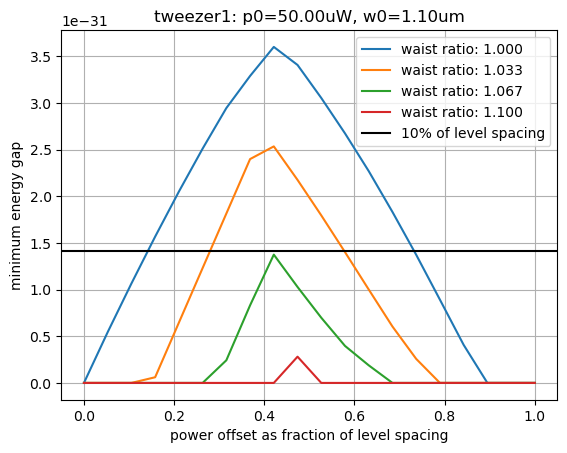

In [29]:
for j, factor_waist2 in enumerate(relative_waists):
    plt.plot(level_spacings, delta_E[:,j],label=f"waist ratio: {factor_waist2:.3f}")

plt.axhline(float(trap.subs(const.hbar*omega_r1))*0.1,color="k",label="10% of level spacing")
    
plt.xlabel("power offset as fraction of level spacing")
plt.ylabel("minimum energy gap")
plt.title(f"tweezer1: p0={initial_power/si.uW:.2f}uW, w0={initial_waist/si.um:.2f}um")
#plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

## Try at different power and waist:

closest approach between states: left:1, right:0


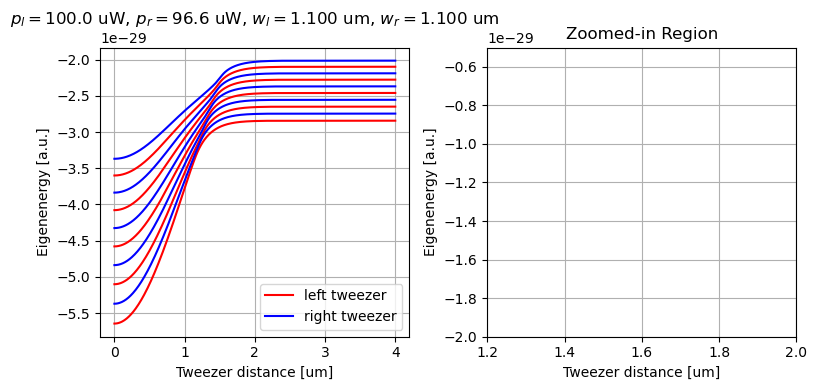

4.071882919254056e-31


In [ ]:
initial_power = 100* si.uW
initial_waist = 1.1*si.uW

factor_waist2 = 1.

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.5*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

In [ ]:
level_spacings = np.linspace(0,1,20)
relative_waists = np.linspace(1,1.1,4)
delta_E = np.full((len(level_spacings),len(relative_waists)),np.nan)

for i, space_fac in enumerate(level_spacings):
    for j, factor_waist2 in enumerate(relative_waists):

        trap[trap.power_tweezer1] = initial_power
        trap[trap.waist_tweezer1] = initial_waist
        trap[trap.waist_tweezer2] = initial_waist*factor_waist2

        omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

        #offset required for 1 level spacing of the left tweezer
        power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

        #factor to match trap depth and offset by half(or another fraction of) the level spacing
        power2_factor = factor_waist2**2 - space_fac*float(trap.subs(power2_offset))/initial_power

        delta_E[i,j] = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10,plot=False)

crossover
crossover
crossover
crossover
closest approach between states: left:4, right:4
crossover
crossover
crossover
closest approach between states: left:4, right:4
crossover
crossover
crossover
closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
crossover
crossover


C:\Users\naeve\AppData\Local\Temp\ipykernel_21460\1111512266.py:24: RuntimeWarning: All-NaN slice encountered
  row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))


closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
crossover
crossover
closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
crossover
crossover
closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
closest approach between states: left:0, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
crossover
closest approach between states: left:0, right:0
closest approach between states: left:1, right:0
crossover
crossover
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
crossover
crossover
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
crossover
crossover
closest approach between states: left:1, right:0
closest approach between states: left:1, right:

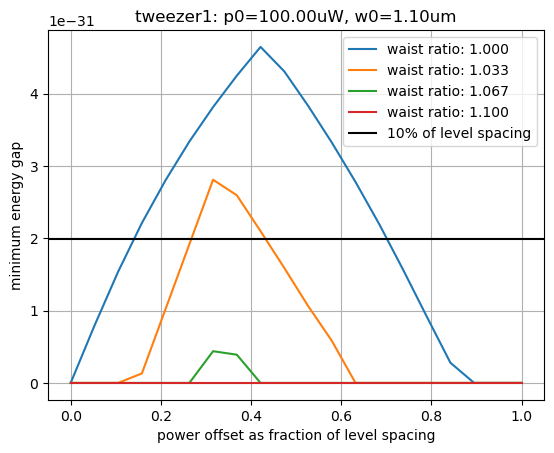

In [32]:
for j, factor_waist2 in enumerate(relative_waists):
    plt.plot(level_spacings, delta_E[:,j],label=f"waist ratio: {factor_waist2:.3f}")

plt.axhline(float(trap.subs(const.hbar*omega_r1))*0.1,color="k",label="10% of level spacing")
    
plt.xlabel("power offset as fraction of level spacing")
plt.ylabel("minimum energy gap")
plt.title(f"tweezer1: p0={initial_power/si.uW:.2f}uW, w0={initial_waist/si.um:.2f}um")
#plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

We see that the energy gap is larger for larger powers. This is expected, since a higher depth also means higher level spacing.

closest approach between states: left:1, right:0


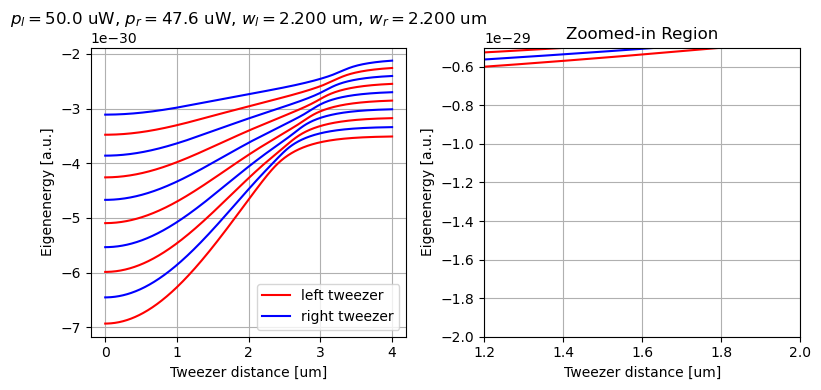

8.084158826331112e-32


In [ ]:
initial_power = 50* si.uW
initial_waist = 2.2*si.uW
initial_distance = 5*si.um

factor_waist2 = 1.

trap[trap.power_tweezer1] = initial_power
trap[trap.waist_tweezer1] = initial_waist
trap[trap.waist_tweezer2] = initial_waist*factor_waist2

omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

#offset required for 1 level spacing of the left tweezer
power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

#factor to match trap depth and offset by half(or another fraction of) the level spacing
power2_factor = factor_waist2**2 - 0.5*float(trap.subs(power2_offset))/initial_power

deltaEs = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10)

print(deltaEs)

In [ ]:
level_spacings = np.linspace(0,1,20)
relative_waists = np.linspace(1,1.1,4)
delta_E = np.full((len(level_spacings),len(relative_waists)),np.nan)

for i, space_fac in enumerate(level_spacings):
    for j, factor_waist2 in enumerate(relative_waists):

        trap[trap.power_tweezer1] = initial_power
        trap[trap.waist_tweezer1] = initial_waist
        trap[trap.waist_tweezer2] = initial_waist*factor_waist2

        omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

        #offset required for 1 level spacing of the left tweezer
        power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

        #factor to match trap depth and offset by half(or another fraction of) the level spacing
        power2_factor = factor_waist2**2 - space_fac*float(trap.subs(power2_offset))/initial_power

        delta_E[i,j] = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10,plot=False)

closest approach between states: left:0, right:0
crossover
crossover
crossover
closest approach between states: left:4, right:4
crossover
crossover
crossover
closest approach between states: left:4, right:4
crossover
crossover
crossover
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
crossover


C:\Users\naeve\AppData\Local\Temp\ipykernel_21460\1111512266.py:24: RuntimeWarning: All-NaN slice encountered
  row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))


closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
crossover
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
crossover
closest approach between states: left:0, right:0
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:4, right:4
closest approach between states: left:0, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between stat

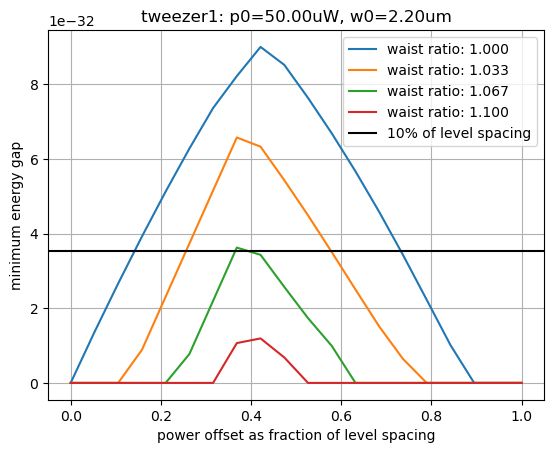

In [35]:
for j, factor_waist2 in enumerate(relative_waists):
    plt.plot(level_spacings, delta_E[:,j],label=f"waist ratio: {factor_waist2:.3f}")

plt.axhline(float(trap.subs(const.hbar*omega_r1))*0.1,color="k",label="10% of level spacing")
    
plt.xlabel("power offset as fraction of level spacing")
plt.ylabel("minimum energy gap")
plt.title(f"tweezer1: p0={initial_power/si.uW:.2f}uW, w0={initial_waist/si.um:.2f}um")
#plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

Larger waists decrease the depth and also the energy gap.

## Let's calculate this for more combinations of power and waist:

In [ ]:
initial_powers = np.linspace(50,1000,10)*si.uW
initial_waists = np.linspace(0.7,2.2,10)*si.um
delta_E = np.full((len(initial_powers),len(initial_waists)),np.nan)

for i, pow in enumerate(initial_powers):
    for j, wai in enumerate(initial_waists):

        space_fac = 0.42
        factor_waist2 = 1

        initial_power = pow
        initial_waist = wai
        initial_distance = 5*si.um

        trap[trap.power_tweezer1] = initial_power
        trap[trap.waist_tweezer1] = initial_waist
        trap[trap.waist_tweezer2] = initial_waist*factor_waist2

        omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

        #offset required for 1 level spacing of the left tweezer
        power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

        #factor to match trap depth and offset by half(or another fraction of) the level spacing
        power2_factor = factor_waist2**2 - space_fac*float(trap.subs(power2_offset))/initial_power

        delta_E[i,j] = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10,plot=False)

C:\Users\naeve\AppData\Local\Temp\ipykernel_21460\1111512266.py:24: RuntimeWarning: All-NaN slice encountered
  row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))


closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach between states: left:0, right:0
closest approach bet

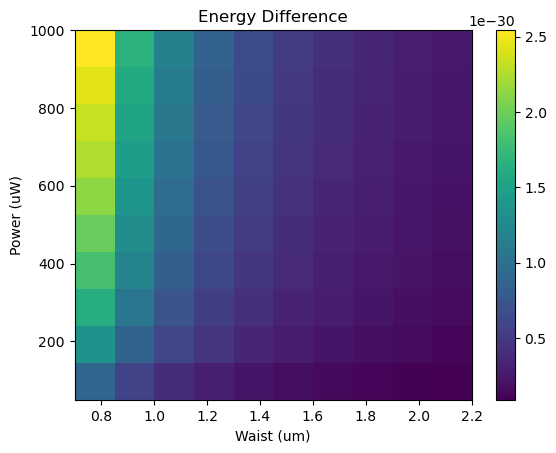

In [37]:
plt.imshow(delta_E,extent=[np.min(initial_waists)/si.uW,np.max(initial_waists)/si.uW,np.min(initial_powers)/si.um,np.max(initial_powers)/si.um],origin="lower",aspect="auto")
plt.colorbar()
plt.ylabel("Power (uW)")
plt.xlabel("Waist (um)")
plt.title("Energy Difference")
plt.show()

In [44]:
initial_powers = np.linspace(50,1000,10)*si.uW
initial_waists = np.linspace(0.7,2.2,10)*si.um
delta_E = np.full((len(initial_powers),len(initial_waists)),np.nan)

for i, pow in enumerate(initial_powers):
    for j, wai in enumerate(initial_waists):

        space_fac = 0.42
        factor_waist2 = 1.05

        initial_power = pow
        initial_waist = wai
        initial_distance = 5*si.um

        trap[trap.power_tweezer1] = initial_power
        trap[trap.waist_tweezer1] = initial_waist
        trap[trap.waist_tweezer2] = initial_waist*factor_waist2

        omega_r1 = sp.sqrt(2*trap.power_tweezer1*trap.a/sp.pi/trap.m)*2/trap.waist_tweezer1**2

        #offset required for 1 level spacing of the left tweezer
        power2_offset = sp.pi*trap.waist_tweezer2**2*const.hbar*omega_r1/2/trap.a

        #factor to match trap depth and offset by half(or another fraction of) the level spacing
        power2_factor = factor_waist2**2 - space_fac*float(trap.subs(power2_offset))/initial_power

        delta_E[i,j] = get_deltaE(initial_power,initial_power*power2_factor,initial_waist,initial_waist*factor_waist2,n_levels=10,plot=False)

C:\Users\naeve\AppData\Local\Temp\ipykernel_21460\382801629.py:24: RuntimeWarning: All-NaN slice encountered
  row_diff = np.nanmin(np.abs(energies_left[:,i] - energies_right[:,j]))


closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
closest approach between states: left:1, right:0
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover
crossover


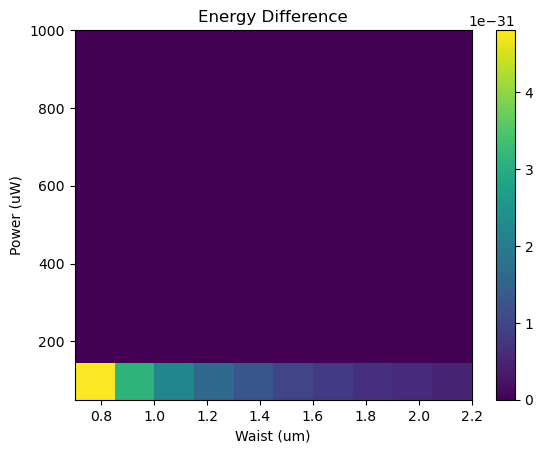

In [45]:
plt.imshow(delta_E,extent=[np.min(initial_waists)/si.uW,np.max(initial_waists)/si.uW,np.min(initial_powers)/si.um,np.max(initial_powers)/si.um],origin="lower",aspect="auto")
plt.colorbar()
plt.ylabel("Power (uW)")
plt.xlabel("Waist (um)")
plt.title("Energy Difference")
plt.show()